# AG_NEWS

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%cd /src
from nets import *
from utils import train, validate
from datasets import AG_NEWS
%cd ..

/content/ChebyKAN
/content/efficient-kan/src
/content


## Data

In [ ]:
ds = "AG_NEWS"
ds_dir = "/data/AG_NEWS"

split="train"
train_dataset = AG_NEWS(data_dir=ds_dir, split=split)
split="valid"
valid_dataset = AG_NEWS(data_dir=ds_dir, split=split)
split="test"
test_dataset = AG_NEWS(data_dir=ds_dir, split=split)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(96000, 24000, 7600)

In [ ]:
ds_dim = train_dataset.data[0].size(dim=0)
no_classes = len(set(train_dataset.target))

model_type = "wide"

print(ds_dim, no_classes)

3072 4


## ChebyKAN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
poly_degree = 1
model_name = "ChebyKAN"

In [ ]:
int(2*ds_dim)

6144

In [ ]:
ChebyKAN_model = ChebyKAN(in_dim=ds_dim, out_dim=no_classes, layers_details=layers_details, degree=poly_degree).to(device)
total_params = sum(p.numel() for p in ChebyKAN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 397568


In [ ]:
for module in ChebyKAN_model.layers:
  if isinstance(module, ChebyKANLayer):
    print(module.inputdim, module.outdim)

3072 64
64 32
32 4


### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(ChebyKAN_model.parameters(), lr=0.0002)
optimizer = optim.AdamW(ChebyKAN_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


 10%|█         | 1/10 [00:05<00:51,  5.67s/it]

Epoch 1, Train Loss: 1.3882, Valid Loss: 1.3901, Valid Acc: 0.25


 20%|██        | 2/10 [00:11<00:44,  5.61s/it]

Epoch 2, Train Loss: 1.2332, Valid Loss: 0.9407, Valid Acc: 0.51


 30%|███       | 3/10 [00:16<00:39,  5.64s/it]

Epoch 3, Train Loss: 0.8821, Valid Loss: 0.8102, Valid Acc: 0.64


 40%|████      | 4/10 [00:22<00:33,  5.66s/it]

Epoch 4, Train Loss: 0.6348, Valid Loss: 0.7080, Valid Acc: 0.65


 50%|█████     | 5/10 [00:28<00:28,  5.65s/it]

Epoch 5, Train Loss: 0.5821, Valid Loss: 0.4864, Valid Acc: 0.81


 60%|██████    | 6/10 [00:33<00:22,  5.65s/it]

Epoch 6, Train Loss: 0.4753, Valid Loss: 0.3835, Valid Acc: 0.86


 70%|███████   | 7/10 [00:39<00:16,  5.61s/it]

Epoch 7, Train Loss: 0.4123, Valid Loss: 0.4156, Valid Acc: 0.85


 80%|████████  | 8/10 [00:45<00:11,  5.69s/it]

Epoch 8, Train Loss: 0.3895, Valid Loss: 0.3512, Valid Acc: 0.88


 90%|█████████ | 9/10 [00:50<00:05,  5.64s/it]

Epoch 9, Train Loss: 0.3766, Valid Loss: 0.4309, Valid Acc: 0.84


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

Epoch 10, Train Loss: 0.3663, Valid Loss: 0.3695, Valid Acc: 0.87


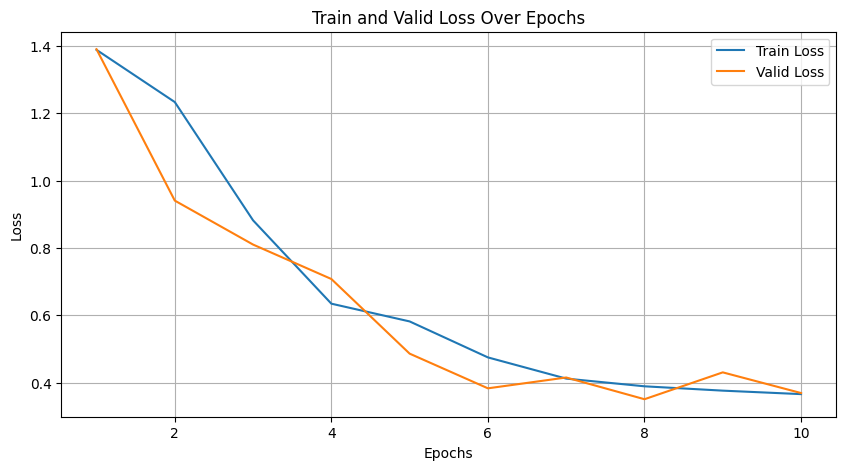

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(ChebyKAN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(ChebyKAN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ChebyKAN_test_loss, ChebyKAN_test_accuracy = validate(ChebyKAN_model, test_loader, criterion, device)

In [ ]:
ChebyKAN_test_loss, ChebyKAN_test_accuracy

(0.3703347183763981, 0.8725)

## EfficientKAN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
poly_degree = 1
model_name = "EfficientKAN"

In [ ]:
EfficientKAN_model = EfficientKAN(layers_hidden=layers_details, spline_order=poly_degree).to(device)
total_params = sum(p.numel() for p in EfficientKAN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 151191552


In [ ]:
for module in EfficientKAN_model.layers:
  if isinstance(module, KANLinear):
    print(module.in_features, module.out_features)

3072 6144
6144 4


### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
optimizer = optim.AdamW(EfficientKAN_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


 10%|█         | 1/10 [01:53<16:58, 113.13s/it]

Epoch 1, Train Loss: 0.5152, Valid Loss: 0.3154, Valid Acc: 0.89


 20%|██        | 2/10 [03:46<15:04, 113.02s/it]

Epoch 2, Train Loss: 0.3120, Valid Loss: 0.3185, Valid Acc: 0.89


 30%|███       | 3/10 [05:38<13:10, 112.97s/it]

Epoch 3, Train Loss: 0.2871, Valid Loss: 0.2921, Valid Acc: 0.90


 40%|████      | 4/10 [07:31<11:17, 112.95s/it]

Epoch 4, Train Loss: 0.2747, Valid Loss: 0.2906, Valid Acc: 0.90


 50%|█████     | 5/10 [09:24<09:24, 112.95s/it]

Epoch 5, Train Loss: 0.2677, Valid Loss: 0.2693, Valid Acc: 0.90


 60%|██████    | 6/10 [11:17<07:31, 112.94s/it]

Epoch 6, Train Loss: 0.2618, Valid Loss: 0.2711, Valid Acc: 0.90


 70%|███████   | 7/10 [13:10<05:38, 112.94s/it]

Epoch 7, Train Loss: 0.2557, Valid Loss: 0.2672, Valid Acc: 0.90


 80%|████████  | 8/10 [15:03<03:45, 112.95s/it]

Epoch 8, Train Loss: 0.2523, Valid Loss: 0.2583, Valid Acc: 0.91


 90%|█████████ | 9/10 [16:56<01:52, 112.94s/it]

Epoch 9, Train Loss: 0.2487, Valid Loss: 0.2509, Valid Acc: 0.91


100%|██████████| 10/10 [18:49<00:00, 112.95s/it]

Epoch 10, Train Loss: 0.2470, Valid Loss: 0.2523, Valid Acc: 0.91


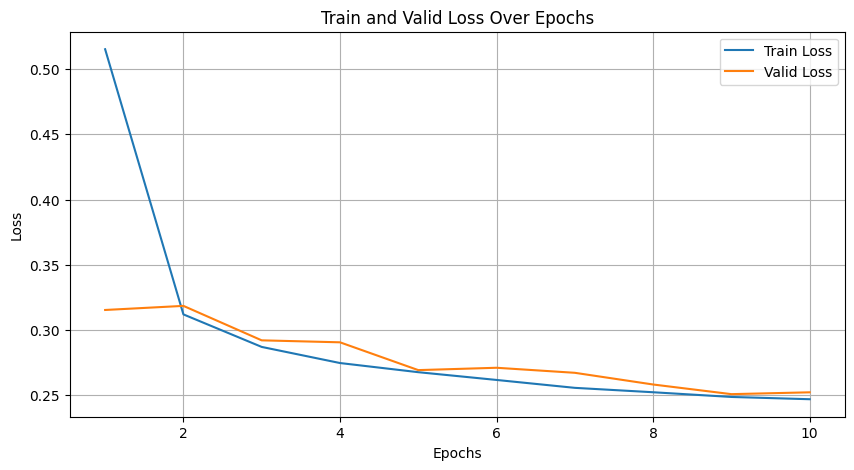

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(EfficientKAN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(EfficientKAN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
EfficientKAN_test_loss, EfficientKAN_test_accuracy = validate(EfficientKAN_model, test_loader, criterion, device)

In [ ]:
EfficientKAN_test_loss, EfficientKAN_test_accuracy

(0.256099846214056, 0.9060526315789473)

## NN Model

In [ ]:
layers_details = [ds_dim, 2*ds_dim, no_classes]
# poly_degree = 3
model_name = "FCN"

In [ ]:
FCN_model = FCN(in_dim=ds_dim, out_dim=no_classes, layers_details=layers_details).to(device)
total_params = sum(p.numel() for p in FCN_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 18905092


In [ ]:
for module in FCN_model.layers:
  if isinstance(module, nn.Linear):
    print(module.in_features, module.out_features)

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
optimizer = optim.AdamW(FCN_model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.SGD(FCN_model.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

cuda is availabe!


 10%|█         | 1/10 [00:13<01:57, 13.04s/it]

Epoch 1, Train Loss: 0.7193, Valid Loss: 0.4085, Valid Acc: 0.87


 20%|██        | 2/10 [00:25<01:43, 12.98s/it]

Epoch 2, Train Loss: 0.4241, Valid Loss: 0.4257, Valid Acc: 0.84


 30%|███       | 3/10 [00:39<01:31, 13.02s/it]

Epoch 3, Train Loss: 0.3886, Valid Loss: 0.3398, Valid Acc: 0.89


 40%|████      | 4/10 [00:51<01:17, 12.97s/it]

Epoch 4, Train Loss: 0.3634, Valid Loss: 0.3349, Valid Acc: 0.88


 50%|█████     | 5/10 [01:04<01:04, 12.92s/it]

Epoch 5, Train Loss: 0.3469, Valid Loss: 0.3784, Valid Acc: 0.87


 60%|██████    | 6/10 [01:17<00:51, 12.88s/it]

Epoch 6, Train Loss: 0.3368, Valid Loss: 0.3811, Valid Acc: 0.87


 70%|███████   | 7/10 [01:30<00:38, 12.87s/it]

Epoch 7, Train Loss: 0.3244, Valid Loss: 0.3271, Valid Acc: 0.88


 80%|████████  | 8/10 [01:43<00:25, 12.89s/it]

Epoch 8, Train Loss: 0.3179, Valid Loss: 0.3041, Valid Acc: 0.90


 90%|█████████ | 9/10 [01:56<00:12, 12.86s/it]

Epoch 9, Train Loss: 0.3111, Valid Loss: 0.3486, Valid Acc: 0.87


100%|██████████| 10/10 [02:08<00:00, 12.90s/it]

Epoch 10, Train Loss: 0.3064, Valid Loss: 0.3191, Valid Acc: 0.89


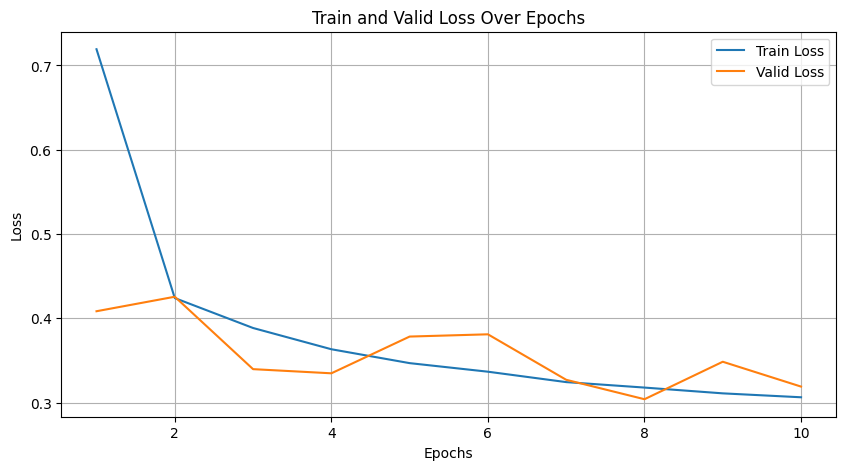

In [ ]:
train_losses = []
valid_losses = []

coeffs_dict = dict()

print(f"{device} is availabe!")

epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train(FCN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(FCN_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}')


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.title('Train and Valid Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
FCN_test_loss, FCN_test_accuracy = validate(FCN_model, test_loader, criterion, device)

In [ ]:
FCN_test_loss, FCN_test_accuracy

(0.3241468630731106, 0.8921052631578947)